In [1]:
!!pip install -q git+https://github.com/ke\ras-team/keras-hub.git
!!pip install -q --upgrade keras  # Upgrade to Keras 3.

['\x1b[?25l   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/1.2 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b1.2/1.2 MB\x1b \x1b47.9 MB/s\x1b eta \x1b0:00:00\x1b',
 "\x1b[?25h\x1bERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.",
 'tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.\x1b\x1b',
 '\x1b']

In [2]:
import os

# Set Keras backend
os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

# Standard Library imports
import json
import math

# Third-party imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import keras
from keras import losses, ops, optimizers, metrics
from keras.optimizers import schedules
from keras.applications.imagenet_utils import decode_predictions
from sklearn.model_selection import KFold
import keras_hub


In [3]:
classifier = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet")

100%|██████████| 840/840 [00:00<00:00, 1.78MB/s]


100%|██████████| 3.54k/3.54k [00:00<00:00, 3.75MB/s]


100%|██████████| 98.1M/98.1M [00:07<00:00, 13.4MB/s]


100%|██████████| 90.2M/90.2M [00:07<00:00, 13.3MB/s]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define the learning rate schedule

In [17]:
def lr_warmup_cosine_decay(
    global_step,
    warmup_steps,
    hold=0,
    total_steps=0,
    start_lr=0.0,
    target_lr=1e-2,
):
    # Cosine decay
    learning_rate = (
        0.5
        * target_lr
        * (
            1
            + ops.cos(
                math.pi
                * ops.convert_to_tensor(
                    global_step - warmup_steps - hold, dtype="float32"
                )
                / ops.convert_to_tensor(
                    total_steps - warmup_steps - hold, dtype="float32"
                )
            )
        )
    )

    warmup_lr = target_lr * (global_step / warmup_steps)

    if hold > 0:
        learning_rate = ops.where(
            global_step > warmup_steps + hold, learning_rate, target_lr
        )

    learning_rate = ops.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, total_steps, hold, start_lr=0.0, target_lr=1e-2):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(
            global_step=step,
            total_steps=self.total_steps,
            warmup_steps=self.warmup_steps,
            start_lr=self.start_lr,
            target_lr=self.target_lr,
            hold=self.hold,
        )
        return ops.where(step > self.total_steps, 0.0, lr)

In [18]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/praeciso/tt",
    image_size=IMAGE_SIZE,
    batch_size=1,
    label_mode='int'
)

images = []
labels = []
gamma_value = 1.3
for image, label in dataset:
    images.append(image[0])
    labels.append(label[0])

    gamma_transformed_image = tf.image.adjust_gamma(image[0], gamma=gamma_value)
    images.append(gamma_transformed_image)
    labels.append(label[0])

images = np.array([img.numpy() for img in images])
labels = np.array([lbl.numpy() for lbl in labels])

# Check the shape to confirm
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Found 330 files belonging to 4 classes.
Images shape: (660, 224, 224, 3)
Labels shape: (660,)


In [19]:
BATCH_SIZE = 64
total_images = 570
total_steps = (total_images // BATCH_SIZE) * 20
warmup_steps = int(0.1 * total_steps)
hold_steps = int(0.45 * total_steps)
schedule = WarmUpCosineDecay(
    start_lr=0.05,
    target_lr=1e-2,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    hold=hold_steps,
)

In [20]:
# Parameters
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 4
NUM_FOLDS = 5
EPOCHS = 20
GAMMA = 1.3


In [21]:
from sklearn.model_selection import StratifiedKFold


kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=43)
fold_no = 1
val_accuracies = []
best_val_accuracy = 0
best_weights = None
best_model = None

train_accuracy_history = []
val_accuracy_history = []

for train_index, val_index in kf.split(images, labels):
    print(f"\nTraining fold {fold_no}...")

    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)


    base_model = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet", num_classes=4, trainable=True)
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(weight_decay=5e-4, learning_rate=schedule, momentum=0.9,),
        metrics=["accuracy"]
    )

    class_weights = {0: 1.0, 1: 1.75, 2: 2.55, 3: 2.80}
    history = model.fit(train_dataset, epochs=20, validation_data=val_dataset , class_weight=class_weights)
    # history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)


    train_accuracy_history.append(history.history['accuracy'])
    val_accuracy_history.append(history.history['val_accuracy'])


    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Fold {fold_no} - Validation Accuracy: {val_accuracy}")


    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_weights = model.get_weights()
        best_model = model

    fold_no += 1



Training fold 1...
Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.2128 - loss: 2.3290 - val_accuracy: 0.1515 - val_loss: 1.3975
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3435 - loss: 2.3060 - val_accuracy: 0.4318 - val_loss: 1.3489
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 563ms/step - accuracy: 0.5438 - loss: 2.2321 - val_accuracy: 0.4545 - val_loss: 1.3320
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 502ms/step - accuracy: 0.6055 - loss: 2.1412 - val_accuracy: 0.5076 - val_loss: 1.2783
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 505ms/step - accuracy: 0.7038 - loss: 1.9859 - val_accuracy: 0.6364 - val_loss: 1.1843
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 499ms/step - accuracy: 0.8052 - loss: 1.6755 - val_accuracy: 0.7121 - val_loss: 1.0352
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 494ms/step - accuracy: 0.8211 - loss: 1.3440 - val_accuracy: 0.7955 - val_loss: 0.8312
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 555ms/step - accuracy: 0.8311 - loss: 0.9513 - val_accuracy: 0.

In [22]:
train_accuracy_history = np.array(train_accuracy_history)
val_accuracy_history = np.array(val_accuracy_history)

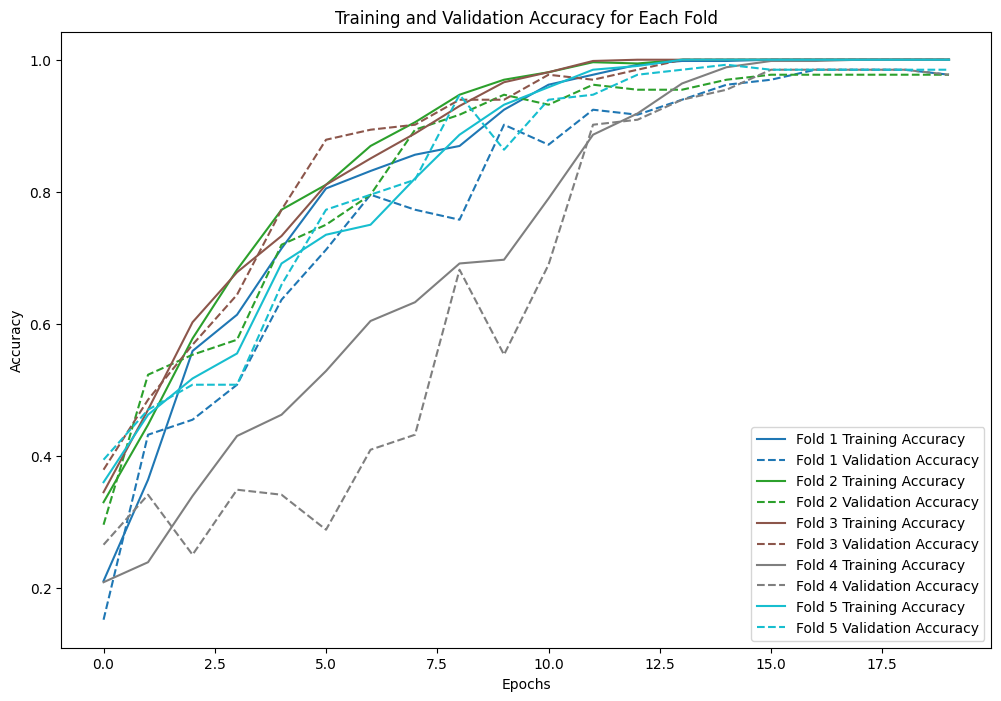

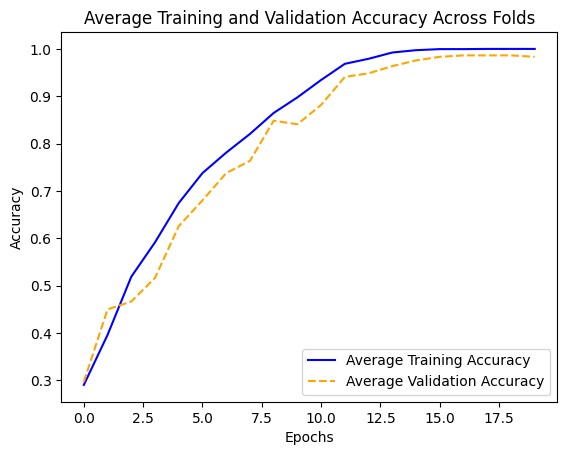

In [23]:
# Define a color palette for the folds
color_palette = plt.cm.tab10(np.linspace(0, 1, NUM_FOLDS))

# Plot training and validation accuracy for each fold
plt.figure(figsize=(12, 8))
for i in range(NUM_FOLDS):
    plt.plot(train_accuracy_history[i], color=color_palette[i], label=f'Fold {i+1} Training Accuracy')
    plt.plot(val_accuracy_history[i], color=color_palette[i], linestyle='--', label=f'Fold {i+1} Validation Accuracy')

plt.title('Training and Validation Accuracy for Each Fold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Calculate mean accuracy across folds for each epoch
mean_train_accuracy = np.mean(train_accuracy_history, axis=0)
mean_val_accuracy = np.mean(val_accuracy_history, axis=0)

# Plot average training and validation accuracy
plt.figure()
plt.plot(mean_train_accuracy, label='Average Training Accuracy', color='blue')
plt.plot(mean_val_accuracy, label='Average Validation Accuracy', color='orange', linestyle='--')
plt.title('Average Training and Validation Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Found 61 files belonging to 4 classes.
Class names from dataset: ['KO', 'OK', 'RzKO', 'RzOK']
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9016 - loss: 0.2900

Test Loss: 0.29003793001174927
Test Accuracy: 0.9016394019126892
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


<Figure size 800x800 with 0 Axes>

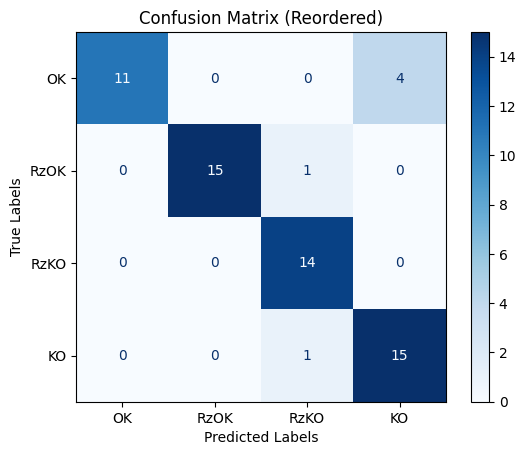

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/praeciso/ttt",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

class_names = test_dataset.class_names
print("Class names from dataset:", class_names)

# Define the desired order of classes
desired_class_order = ["OK", "RzOK", "RzKO", "KO"]

# Map the dataset's class names to the desired order
class_name_mapping = {name: idx for idx, name in enumerate(class_names)}
desired_order_indices = [class_name_mapping[name] for name in desired_class_order]

# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Get predictions and true labels
y_pred = []
y_true = []

for images, labels in test_dataset:
    predictions = best_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Reorder the confusion matrix according to the desired class order
conf_matrix_reordered = conf_matrix[desired_order_indices, :]
conf_matrix_reordered = conf_matrix_reordered[:, desired_order_indices]

# Plot the reordered confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_reordered, display_labels=desired_class_order)

plt.figure(figsize=(8, 8))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Reordered)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


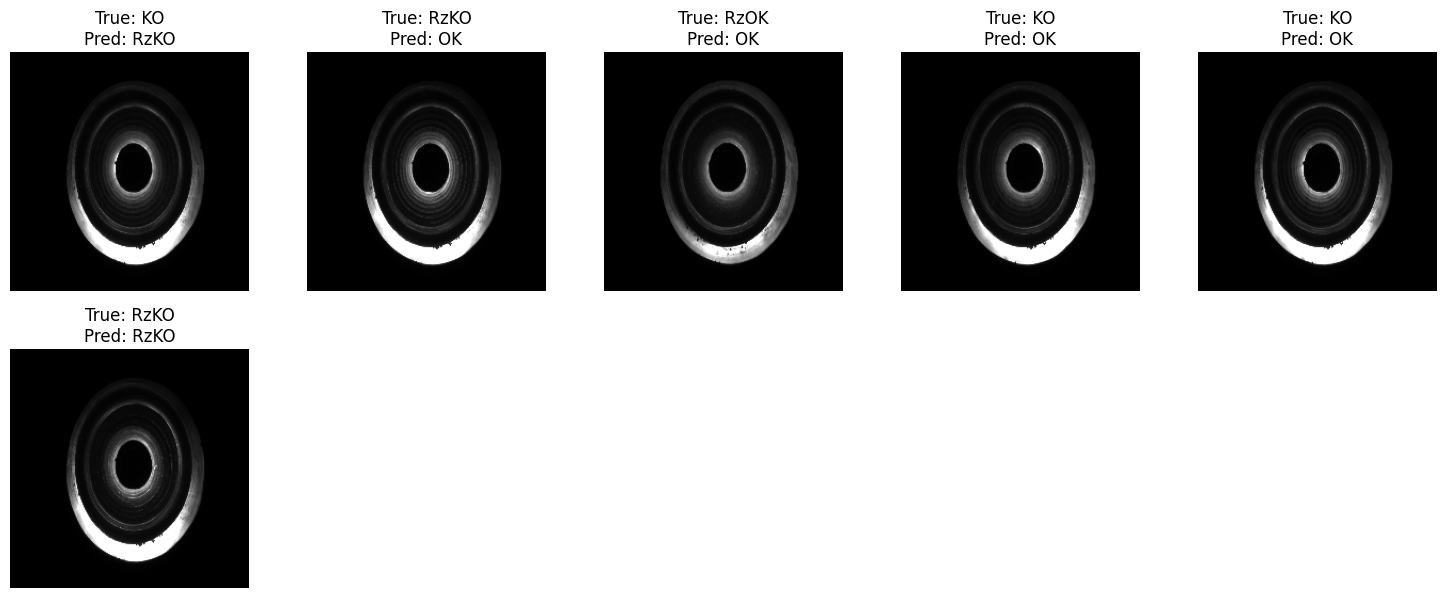

In [27]:
import matplotlib.pyplot as plt

# Get misclassified indices
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]

# Retrieve the misclassified images and their labels
misclassified_images = []
misclassified_true_labels = []
misclassified_pred_labels = []

for idx, (images, labels) in enumerate(test_dataset.unbatch()):
    if idx in misclassified_indices:
        misclassified_images.append(images.numpy())
        misclassified_true_labels.append(labels.numpy())
        misclassified_pred_labels.append(y_pred[idx])
        if len(misclassified_images) >= 25:  # Limit to 25 images for display
            break

# Plot the misclassified samples
plt.figure(figsize=(15, 15))
for i in range(len(misclassified_images)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(misclassified_images[i].astype("uint8"))
    plt.title(f"True: {desired_class_order[misclassified_true_labels[i]]}\nPred: {desired_class_order[misclassified_pred_labels[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [39]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/praeciso/tt",
    image_size=IMAGE_SIZE,
    batch_size=1,
    label_mode='int'
)

images = []
labels = []
gamma_value = 1.3
for image, label in dataset:
    images.append(image[0])
    labels.append(label[0])

    gamma_transformed_image = tf.image.adjust_gamma(image[0], gamma=gamma_value)
    images.append(gamma_transformed_image)
    labels.append(label[0])

images = np.array([img.numpy() for img in images])
labels = np.array([lbl.numpy() for lbl in labels])

# Check the shape to confirm
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Found 330 files belonging to 4 classes.
Images shape: (660, 224, 224, 3)
Labels shape: (660,)


In [40]:
BATCH_SIZE = 64
total_images = len(images)
total_steps = (total_images // BATCH_SIZE) * 15
warmup_steps = int(0.1 * total_steps)
hold_steps = int(0.45 * total_steps)
schedule = WarmUpCosineDecay(
    start_lr=0.05,
    target_lr=1e-2,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    hold=hold_steps,
)

In [41]:
final_model = keras.Model(inputs=inputs, outputs=outputs)
final_model.set_weights(best_weights)


final_model.compile(
    loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(weight_decay=5e-4, learning_rate=schedule, momentum=0.9,),
    metrics=["accuracy"]
)


full_train_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
full_train_dataset = full_train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

history = final_model.fit(full_train_dataset, epochs=15)

Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.9966 - loss: 0.0305
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 465ms/step - accuracy: 1.0000 - loss: 0.0233
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 473ms/step - accuracy: 1.0000 - loss: 0.0175
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 498ms/step - accuracy: 1.0000 - loss: 0.0129
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 492ms/step - accuracy: 1.0000 - loss: 0.0105
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 479ms/step - accuracy: 1.0000 - loss: 0.0090
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 468ms/step - accuracy: 1.0000 - loss: 0.0079
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 462ms/step - accuracy: 1.0000 - loss: 0.0071
Epoch 9/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - accuracy: 1.0000 - loss: 0.0064
Epoch 10/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 452ms/step - accuracy: 1.0000 - loss: 0.0060
Epoch 11/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 451ms/step - accuracy: 1.0000 - loss: 0.0056
Epoch 12/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 451ms/step 

Available metrics in history: dict_keys(['accuracy', 'loss'])


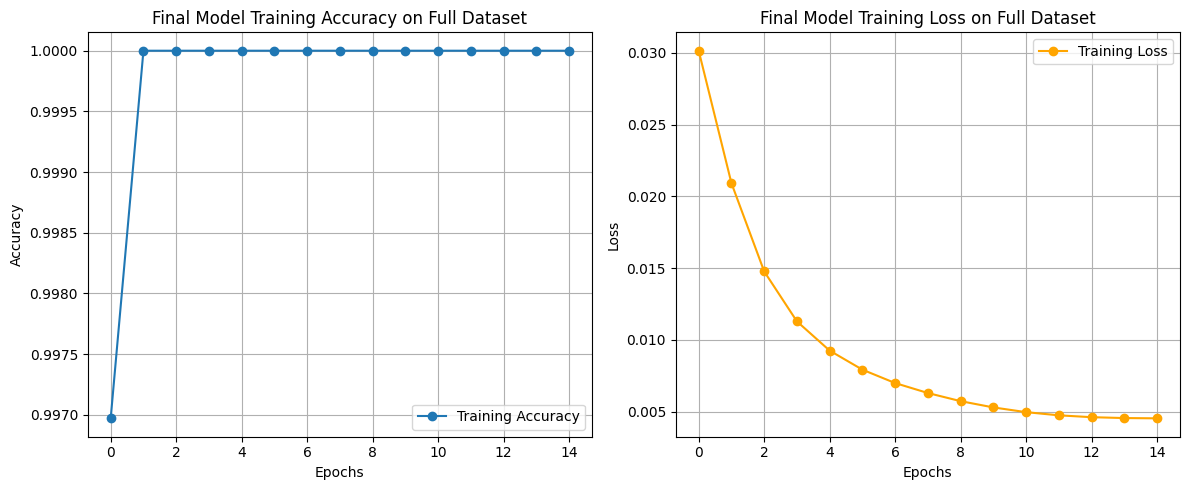

In [42]:
# Train the final model

# Debugging: Check if 'loss' and 'accuracy' exist in history
print("Available metrics in history:", history.history.keys())
if 'loss' not in history.history or 'accuracy' not in history.history:
    raise ValueError("Loss or accuracy not found in the training history. Check the model configuration.")

# Plotting the metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.title('Final Model Training Accuracy on Full Dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o', color='orange')
plt.title('Final Model Training Loss on Full Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Found 61 files belonging to 4 classes.
Class names from dataset: ['KO', 'OK', 'RzKO', 'RzOK']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6393 - loss: 0.7691

Test Loss: 0.7691165208816528
Test Accuracy: 0.6393442749977112
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


<Figure size 800x800 with 0 Axes>

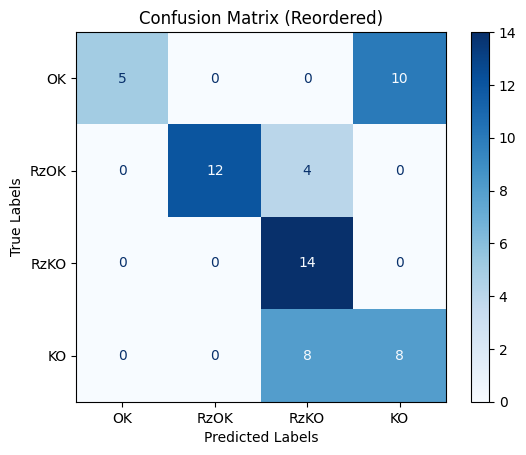

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/praeciso/ttt",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

class_names = test_dataset.class_names
print("Class names from dataset:", class_names)

# Define the desired order of classes
desired_class_order = ["OK", "RzOK", "RzKO", "KO"]

# Map the dataset's class names to the desired order
class_name_mapping = {name: idx for idx, name in enumerate(class_names)}
desired_order_indices = [class_name_mapping[name] for name in desired_class_order]

# Evaluate the model
test_loss, test_accuracy = final_model.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Get predictions and true labels
y_pred = []
y_true = []

for images, labels in test_dataset:
    predictions = final_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Reorder the confusion matrix according to the desired class order
conf_matrix_reordered = conf_matrix[desired_order_indices, :]
conf_matrix_reordered = conf_matrix_reordered[:, desired_order_indices]

# Plot the reordered confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_reordered, display_labels=desired_class_order)

plt.figure(figsize=(8, 8))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Reordered)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
